In [1]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf

print("Number of available GPUs:", len(tf.config.list_physical_devices('GPU')))


Number of available GPUs: 0


In [ ]:
'''
df = pd.read_csv('./data/X_train.csv')
df = pd.merge(df, pd.read_csv('./data/y_train.csv'), on='id')
df = df.drop(columns='id', axis=0)
df.to_csv('./data/df_train.csv')
'''

In [10]:
df = pd.read_csv('./data/df_train.csv')

In [11]:
# Replace NaN with zeros

#df = df.fillna(0)
df = df.drop(columns='Unnamed: 0', axis=0)


In [4]:
df['y'].value_counts()

y
0    3030
2    1474
1     443
3     170
Name: count, dtype: int64

In [12]:
import biosppy.signals.ecg as ecg
from scipy.signal import resample
from scipy.signal import resample_poly


def extract_and_resample_heartbeats(raw_ecg_data, target_length=180, sampling_rate=300, min_rr=100, df_train=None):
    raw_ecg_data = raw_ecg_data[~np.isnan(raw_ecg_data)]
    
    rpeaks = ecg.engzee_segmenter(raw_ecg_data, sampling_rate=sampling_rate)['rpeaks']
    
    if len(rpeaks) >= 2:
        heartbeat_info = ecg.extract_heartbeats(raw_ecg_data, rpeaks, sampling_rate)
        heartbeats = heartbeat_info['templates']
        
        # Ensure consistent length using resample or zero-padding
        resampled_heartbeats = [resample_poly(heartbeat, target_length, len(heartbeat)) for heartbeat in heartbeats]
        
        return resampled_heartbeats
    else:
        # Return the average heartbeat of class 0 as a default
        if df_train is not None:
            average_heartbeat_class_0 = df_train[df_train['y'] == 0].iloc[:, :-1].mean(axis=0).to_numpy(dtype='float32')
            return [average_heartbeat_class_0]
        else:
            return None

In [14]:

ecg_labels = df['y']
target_length = 180

processed_data_with_resampled_heartbeats = {'id': [], 'y': []}

for i in range(target_length):
    processed_data_with_resampled_heartbeats[i] = []

for index, row in df.iterrows():
    raw_ecg_data = row[:-1].dropna().to_numpy(dtype='float32')
    
    resampled_heartbeats = extract_and_resample_heartbeats(raw_ecg_data)
    
    if resampled_heartbeats is not None:
        for i, resampled_heartbeat in enumerate(resampled_heartbeats):
            processed_data_with_resampled_heartbeats['id'].append(index)
            processed_data_with_resampled_heartbeats['y'].append(row['y'])
            for j, value in enumerate(resampled_heartbeat):
                processed_data_with_resampled_heartbeats[j].append(value)

processed_df = pd.DataFrame(processed_data_with_resampled_heartbeats)

print(processed_df.shape)


(177949, 182)


In [15]:
processed_df.to_csv('./data/df_heartbeats.csv')

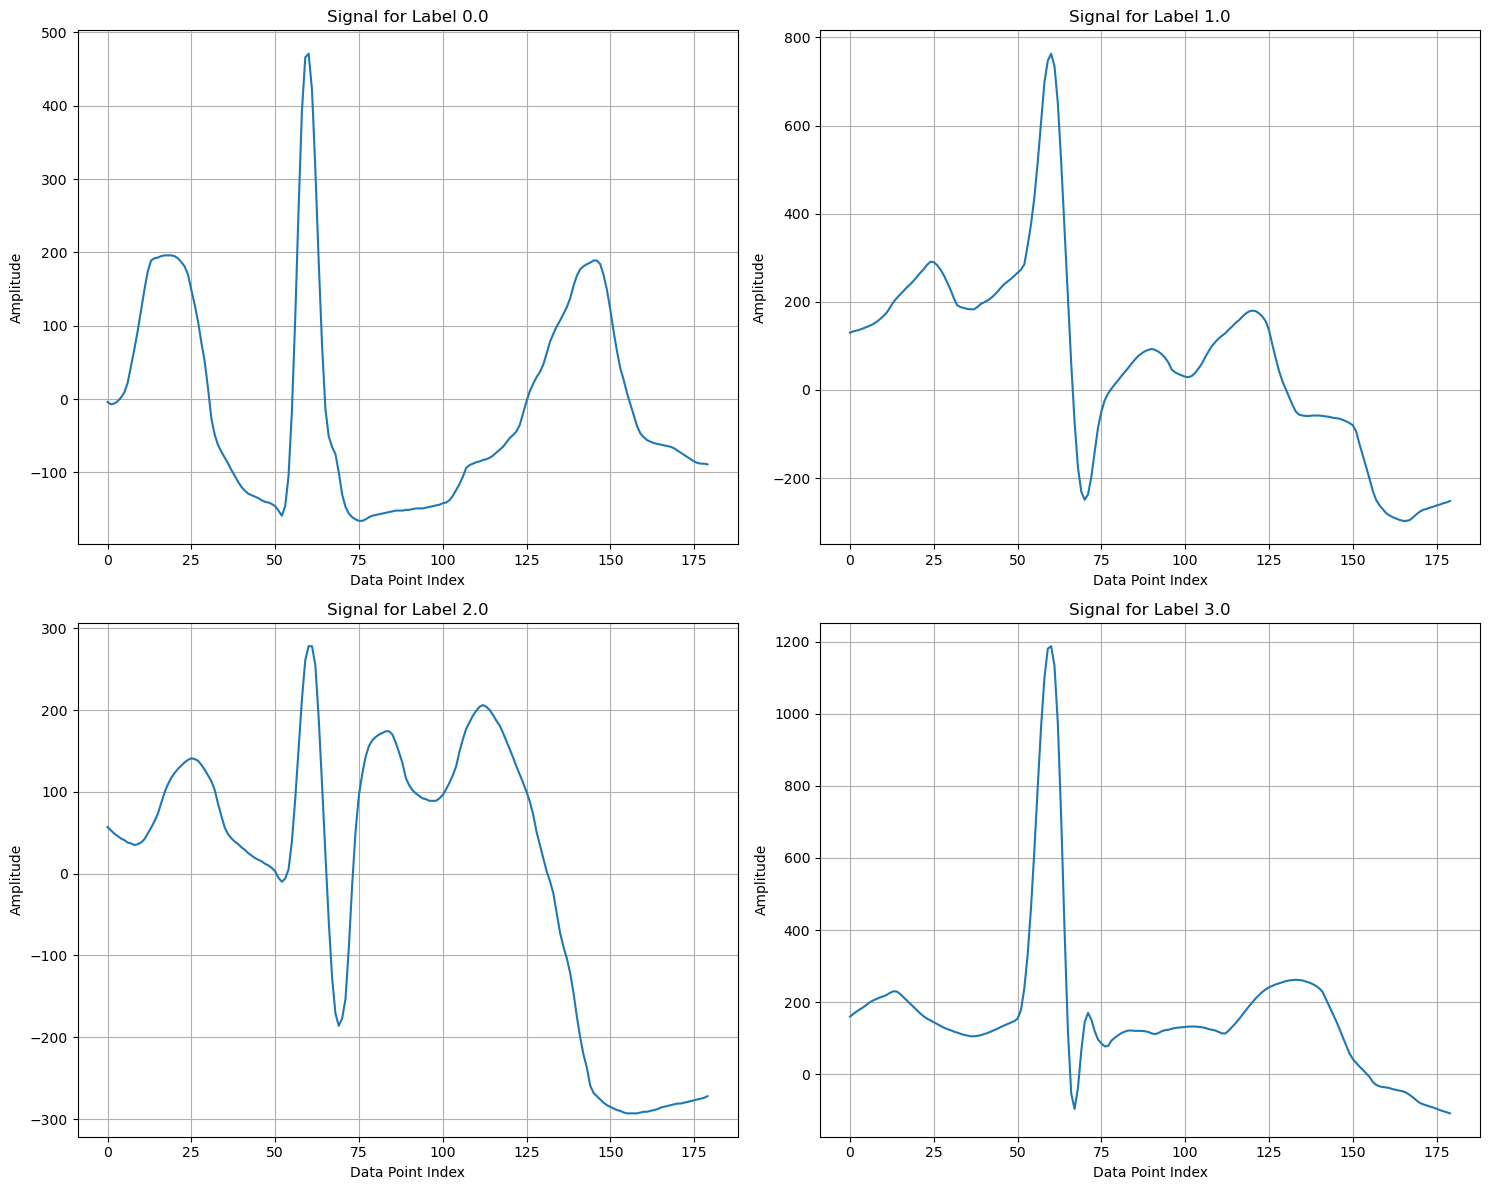

In [6]:
import matplotlib.pyplot as plt

# Plot 4 signals, one for each class, in one big figure
labels_to_plot = processed_df['y'].unique()

plt.figure(figsize=(15, 12))

for i, label in enumerate(labels_to_plot, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    label_data = processed_df[processed_df['y'] == label].drop(['y'], axis=1).iloc[0]
    plt.plot(label_data)
    plt.title(f'Signal for Label {label}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()


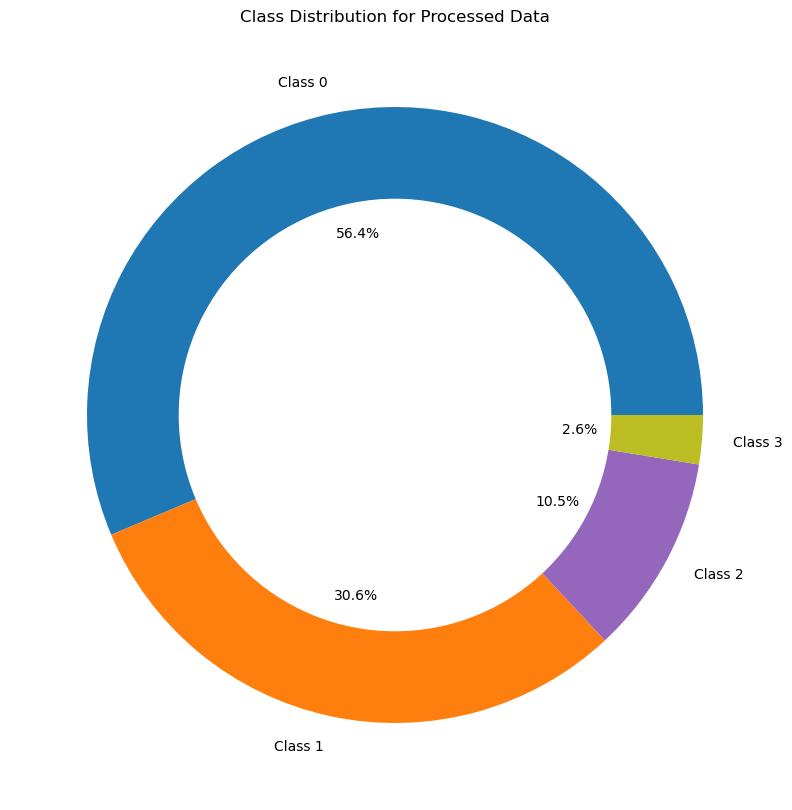

In [7]:

# representation of classes % wise
per_class_processed = processed_df['y'].value_counts()
plt.figure(figsize=(20, 10))
my_circle_processed = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class_processed, labels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive'], autopct='%1.1f%%')
p_processed = plt.gcf()
p_processed.gca().add_artist(my_circle_processed)
plt.title('Class Distribution for Processed Data')
plt.show()



In [8]:
df_test = pd.read_csv('./data/X_test.csv')
df_train = pd.read_csv('./data/df_heartbeats.csv')
df_train = df_train.drop(columns='Unnamed: 0', axis=0)

ecg_ids = df_test['id']
target_length = 180

processed_data_with_resampled_heartbeats = {'id': []}


for i in range(target_length):
    processed_data_with_resampled_heartbeats[i] = []

for index, row in df_test.iterrows():
    raw_ecg_data = row[:-1].dropna().to_numpy(dtype='float32')
    
    resampled_heartbeats = extract_and_resample_heartbeats(raw_ecg_data, df_train=df_train)
    
    if resampled_heartbeats is not None:
        for i, resampled_heartbeat in enumerate(resampled_heartbeats):
            processed_data_with_resampled_heartbeats['id'].append(row['id'])
            for j, value in enumerate(resampled_heartbeat):
                processed_data_with_resampled_heartbeats[j].append(value)

processed_df_test = pd.DataFrame(processed_data_with_resampled_heartbeats)


print(processed_df_test.shape)


(118179, 181)


In [9]:
processed_df_test.to_csv('./data/X_test_heartbeats.csv')

In [9]:
processed_df.to_csv('./data/df_heartbeats.csv')
processed_df_test.to_csv('./data/X_test_heartbeats.csv')

## Splitting data

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
y = df['y']

# Splitting the data into training (80%) and temporary (20%)
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert the train and test splits into dataframes
df_train = pd.DataFrame(df_train, columns=X.columns)
df_test = pd.DataFrame(df_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=['y'])
y_test = pd.DataFrame(y_test, columns=['y'])


In [ ]:
df_train = pd.concat([df_train, y_train], axis=1)
df_test = pd.concat([df_test, y_test], axis=1)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## Preprocessing

In [ ]:
# Resampling

from sklearn.utils import resample

df_1 = df_train[df_train['y'] == 1]
df_2 = df_train[df_train['y'] == 2]
df_3 = df_train[df_train['y'] == 3]
df_0 = df_train[df_train['y'] == 0].sample(n=2000, random_state=42)

df_1_upsample = resample(df_1, replace=True, n_samples=2000, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=2000, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=2000, random_state=125)

df_train = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample])


In [ ]:
# representation of classes % wise
per_class = df_train['y'].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['Class 0','Class 2','Class 1','Class 3'], colors=['tab:blue','tab:orange','tab:purple','tab:olive'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()



In [ ]:
# Pre Trearment (noise)

def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,df_train.shape[1]-1)
    return (signal+noise)

In [ ]:
classes=df_train.groupby('y',group_keys=False).apply(lambda df_train : df_train.sample(1))
tempo=classes.iloc[0,:df_train.shape[1]-1]
bruiter=add_gaussian_noise(tempo)

In [ ]:
from keras.utils import to_categorical

target_train=df_train['y']
target_test=df_test['y']
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [ ]:
X_train=df_train.iloc[:,:df_train.shape[1]-1].values
X_test=df_test.iloc[:,:df_test.shape[1]-1].values

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [ ]:
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1], 1)  # Modify the input shape to match your data shape
    inputs_cnn=Input(shape=im_shape, name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(4, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=50,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

model,history=network(X_train,y_train,X_test,y_test)



In [ ]:
from sklearn.metrics import f1_score

evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

# Calculate micro-averaged F1 score
y_true_micro = np.argmax(y_test, axis=1)
y_pred_micro = np.argmax(y_pred, axis=1)
f1_micro = f1_score(y_true_micro, y_pred_micro, average='micro')
print("f1 score:", f1_micro)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)


## Create X_test file

In [ ]:
df_true_test = pd.read_csv('./data/X_test.csv')
df_true_test_ids = pd.read_csv('./data/X_test.csv')['id']

df_true_test.fillna(0, inplace=True)

X_true_test = df_true_test.values.reshape(len(df_true_test), df_true_test.shape[1], 1)
y_true_test_pred = model.predict(X_true_test)

df_y_pred_true_test = pd.DataFrame({'id': df_true_test_ids, 'y': np.argmax(y_true_test_pred, axis=1)}, dtype=int)

df_y_pred_true_test.to_csv('./data/y_pred_CNN.csv', index=False)
